# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [37]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',low_memory=False)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',low_memory=False)

In [3]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Generate descriptive statistics that summarize the azdias dataframe
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
# find data that is 'naturally missing' in dataset
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100

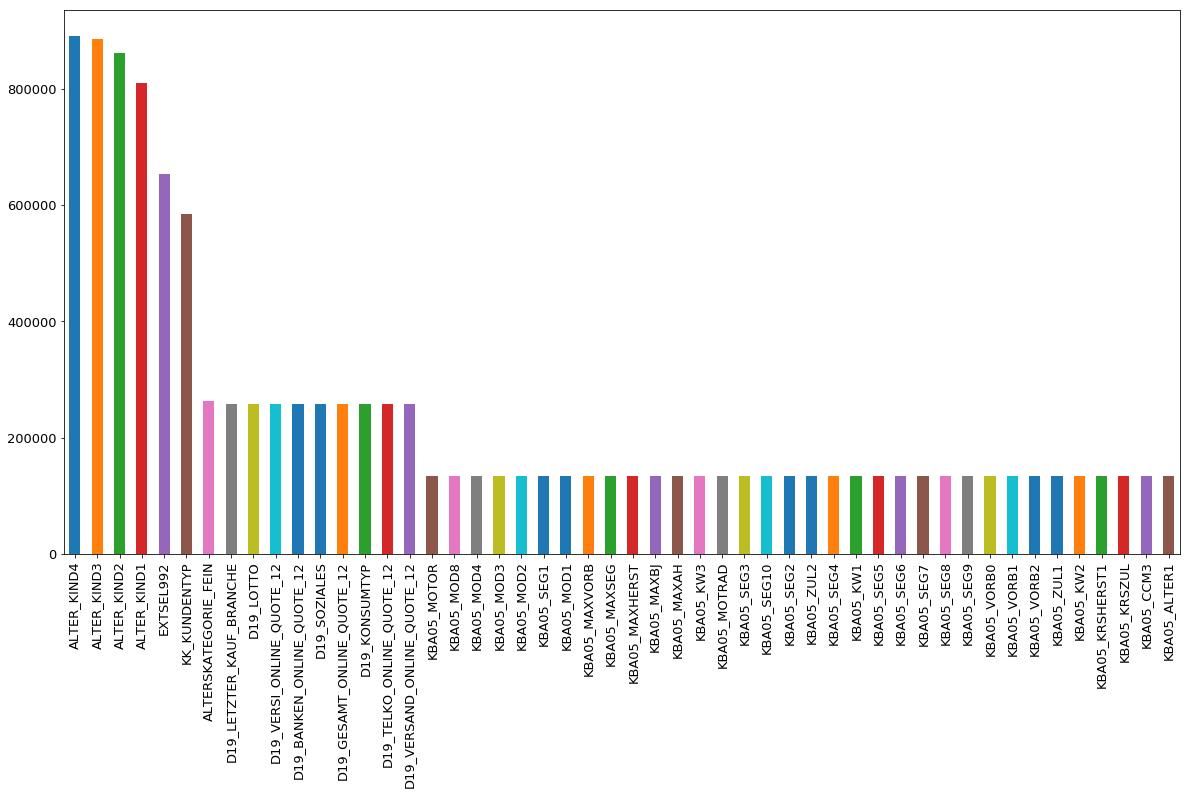

In [7]:
# visualise natually missing data
(azdias_null.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,10), fontsize=13))

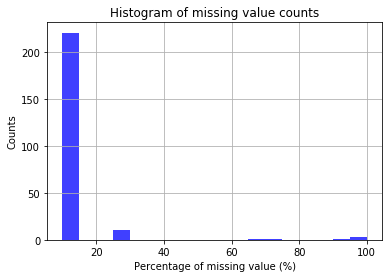

% of missing data in columns 
 ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB             

In [8]:
# get dstirbution of empty data in fields by percentage
plt.hist(azdias_null_percent, bins = np.linspace(10,100,19), facecolor='b', alpha=0.75)

plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Histogram of missing value counts')
plt.grid(True)
plt.show()
# % of missing data in columns
print('% of missing data in columns','\n',azdias_null_percent.sort_values(ascending=False))

Text(0.5,0,'prop. of missing values')

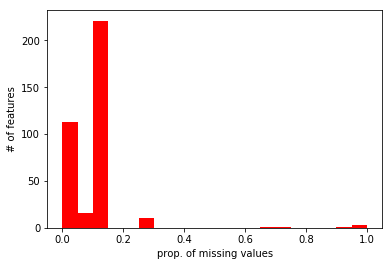

In [9]:
# visualization of distribution trend 
column_nans = azdias.isnull().mean()

plt.hist(column_nans, bins = np.arange(0,1+.05,.05),facecolor='r')
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')

# Data Preprocessing

In [10]:
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)
azdias_dropped = azdias[azdias.isnull().sum(axis=1) > 9].reset_index(drop=True)
print('number of rows in new dataset: ',azdias.shape[0])
print('number of rows dropped: ', azdias_dropped.shape[0])

number of rows in new dataset:  733227
number of rows dropped:  163978



#### from above we can see that there is significant difference on % of data missing. >65 is only 6 columns and this is a significant missing data.So let's drop these 6 columns

In [11]:
drop_cols = azdias.columns[column_nans > 0.65]
print('columns to drop: ', drop_cols)

columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [12]:
# Before dropping data on azdias lets preprocess customers dataset and get it ready for further processing
# Drop the extra column of customers dataset.

customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [13]:
print('# of column in azdias before dropping: ', len(azdias.columns))
azdias = azdias.drop(drop_cols,axis=1)
print('# of column in azdias after dropping: ', len(azdias.columns))

print('# of column in customers before dropping: ', len(customers.columns))
customers = customers.drop(drop_cols,axis=1)
print('# of column in customers after dropping: ', len(customers.columns))

# of column in azdias before dropping:  366
# of column in azdias after dropping:  360
# of column in customers before dropping:  366
# of column in customers after dropping:  360


In [14]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 360)
number of rows in new dataset:  (191652, 360)


In [15]:
# object field EINGEFUEGT_AM has too many different items. Dropping from dataset

azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

In [16]:
# object field D19_LETZTER_KAUF_BRANCHE has many different items. Dropping from dataset

azdias = azdias.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers = customers.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

In [17]:
# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))

number of columns 238
number of columns 256


In [18]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 238)
number of rows in new dataset:  (191652, 256)


In [19]:
# we have removed columns that has mostly missing values and do not add value. Let's explore columns with object data type.
azdias.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,8A,8,51,W
1,4C,4,24,W
2,2A,2,12,W
3,6B,6,43,W
4,8C,8,54,W
5,4A,4,22,W
6,2D,2,14,W
7,1A,1,13,W
8,1E,1,15,W
9,9D,9,51,W


In [20]:
customers.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,1A,1,13,W
1,NaN,NaN,NaN,NaN
2,5D,5,34,W
3,4C,4,24,W
4,7B,7,41,W


In [21]:
# before going ahead with encoding we need to find categorical fields - below 1 hack option to do it

cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('num_cols: ',num_cols)


num_cols:  Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=234)


In [22]:
# we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [23]:
customers.isnull().sum()

LNR                             0
AGER_TYP                        0
AKT_DAT_KL                  46596
ALTER_HH                    46596
ALTERSKATEGORIE_FEIN        51842
ANZ_HAUSHALTE_AKTIV         49927
ANZ_HH_TITEL                52110
ANZ_KINDER                  46596
ANZ_PERSONEN                46596
ANZ_TITEL                   46596
ARBEIT                      50476
BALLRAUM                    49959
CAMEO_DEU_2015                  0
CAMEO_DEUG_2015                 0
CAMEO_INTL_2015                 0
CJT_GESAMTTYP                3213
CJT_KATALOGNUTZER            3213
CJT_TYP_1                    3213
CJT_TYP_3                    3213
CJT_TYP_6                    3213
D19_BANKEN_ANZ_12               0
D19_BANKEN_DIREKT               0
D19_BANKEN_GROSS                0
D19_BANKEN_LOKAL                0
D19_BANKEN_OFFLINE_DATUM        0
D19_BANKEN_REST                 0
D19_BEKLEIDUNG_GEH              0
D19_BEKLEIDUNG_REST             0
D19_BILDUNG                     0
D19_BIO_OEKO  

In [24]:
azdias.isnull().sum()

LNR                              0
AGER_TYP                         0
AKT_DAT_KL                       0
ALTER_HH                         0
ALTERSKATEGORIE_FEIN        167182
ANZ_HAUSHALTE_AKTIV              0
ANZ_HH_TITEL                  2783
ANZ_KINDER                       0
ANZ_PERSONEN                     0
ANZ_TITEL                        0
ARBEIT                        2948
BALLRAUM                       418
CAMEO_DEU_2015                   0
CAMEO_DEUG_2015                  0
CAMEO_INTL_2015                  0
CJT_GESAMTTYP                    0
CJT_KATALOGNUTZER                0
CJT_TYP_1                        0
CJT_TYP_6                        0
D19_BANKEN_ANZ_12                0
D19_BANKEN_DIREKT                0
D19_BANKEN_GROSS                 0
D19_BANKEN_LOKAL                 0
D19_BANKEN_OFFLINE_DATUM         0
D19_BANKEN_REST                  0
D19_BEKLEIDUNG_GEH               0
D19_BEKLEIDUNG_REST              0
D19_BILDUNG                      0
D19_BIO_OEKO        

In [25]:
# fillna with 9 for fields that has 9 marked as unknown

azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

In [26]:
# fillna with 0 for fields that has 0 marked as unknown

azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

In [27]:
# fillna with -1 for fields that has 0 marked as unknown

azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

In [28]:
#with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding

azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

In [29]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 284)
number of rows in new dataset:  (191652, 303)


In [30]:
azdias_columns = azdias.columns
customers_columns = customers.columns
print(azdias.columns)
print(customers.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=284)
Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_-1', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=303)


In [31]:
# impute nans using mode value

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('imputed azdias: ', azdias.head(5))

customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('imputed customers: ', customers.head(5))

imputed azdias:          0    1    2     3     4     5    6    7    8    9   ...   274  275  \
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  0.0 ...   0.0  0.0   
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0  0.0 ...   0.0  0.0   
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0  0.0 ...   0.0  0.0   
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0  0.0 ...   1.0  0.0   

   276  277  278  279  280  281  282  283  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 284 columns]
imputed customers:          0    1    2     3     4    5    6    7    8    9   ...   293  294  \
0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  0.0 ...   0.0  0.0   
1    9628.0 -1.0  9.0  11.0   9.0  9.0  9.0  0.0  3.

In [32]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 284)
number of rows in new dataset:  (191652, 303)


In [33]:
# convert to int
azdias = azdias.astype(int)
customers = customers.astype(int)

## Remove outlier data

In [38]:
#  remove all rows that have outliers in at least one column

azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

In [39]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (415405, 284)
number of rows in new dataset:  (100341, 303)


In [40]:
azdias.head()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
1,910225,-1,9,17,17,10,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,910241,-1,1,20,14,3,0,0,4,0,...,0,0,0,0,0,0,0,0,0,1
4,910244,3,1,10,10,5,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
5,910248,-1,9,0,9,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,910261,-1,1,14,14,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Standardize data


In [41]:
# scale the data
scale = StandardScaler(copy=False)

#scale = MinMaxScaler(copy=False)
azdias[azdias.columns] = scale.fit_transform(azdias)

In [42]:
azdias.columns = azdias_columns

In [43]:
azdias_columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=284)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

After data preprocessing step we could find that general population data (azdias) now has 415405 rows and 283 columns. Even though we have dropped not-so important features and outlier data, this is still high dimensional data and this is where we will be using Principal Component to reduce dimension.

#### Perform Dimensionality Reduction
On the scaled data, dimensionality reduction techniques can now be applied.

1. sklearn's PCA class will be used to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, at least half the number of features will be set (so there's enough features to see the general trend in variability).
2. The ratio of variance explained by each principal component as well as the cumulative variance explained will be checked by plotting the cumulative or sequential values using matplotlib's plot() function. Based on the findings, a value for the number of transformed features will be retained for the clustering part of the project.
3. Once a choice for the number of components to keep has been made, the PCA instance will be re-fit to perform the decided-on transformation.

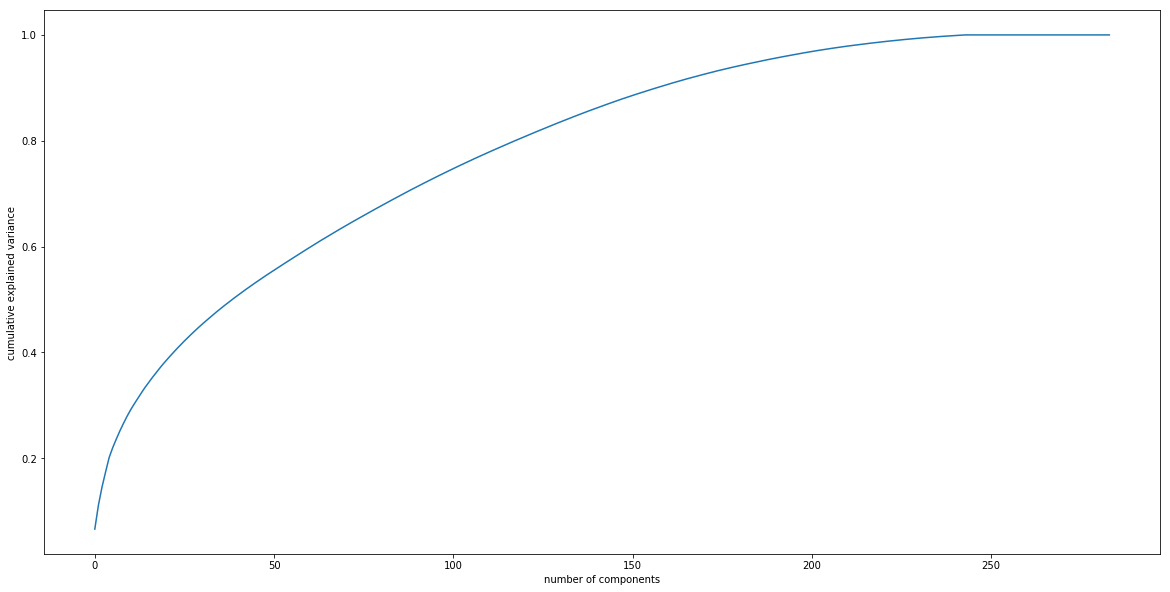

In [77]:
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [78]:
def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

With PCA we want to make our data has high variance. This way we do not lose critical information from dataset while reducing dimensions. Based on above chart we can see that at around 220 components, cumulative variance is still high. Let us reduce our data with 220 components

In [80]:
def reduce_data(df,n=220):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [81]:
reduced_azdias = reduce_data(azdias)
reduced_customers = reduce_data(customers)

0.98630971121
0.999999999483


In [82]:
print('number of rows in new dataset: ',reduced_azdias.shape)
print('number of rows in new dataset: ',reduced_customers.shape)

number of rows in new dataset:  (415405, 220)
number of rows in new dataset:  (100341, 220)


## Clustering

#### Apply Clustering to General Population
With dimension now reduced, let's do clustering. To decide on number of clusters, we will try using elbow method, k-means clustering will be applied to the dataset and the average within-cluster distances from each point to their assigned cluster's centroid will be used to decide on a number of clusters to keep.

1. sklearn's KMeans class will be used to perform k-means clustering on the PCA-transformed data.
2. Then, the average difference from each point to its assigned cluster's center will be computed.
3. The above two steps will be performed for a 30 different cluster counts to see how the average distance decreases with an increasing number of clusters.
4. Once final number of clusters to use is selected, KMeans instance will be re-fit to perform the clustering operation.

In [84]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

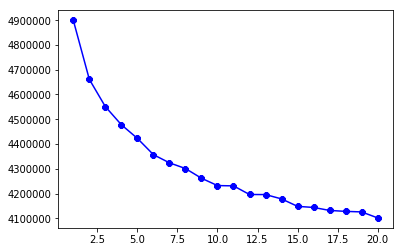

In [86]:
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='8', color='blue')

Text(0.5,0,'Number of Clusters')

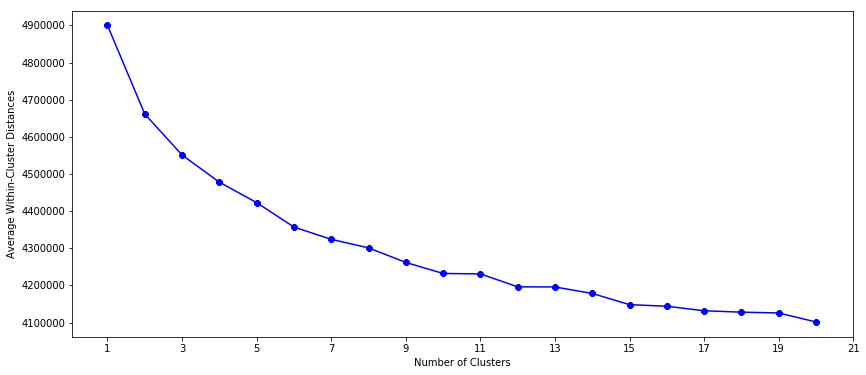

In [87]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='8', color='blue')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [88]:
#from above chart we can see that at around 12 clusters, average distance within cluster almost flattens. 
#We will use 12 as number of clusters

kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)

In [89]:
azdias_clustered = pd.DataFrame(prediction _azdias, columns = ['Cluster'])
azdias_clustered.to_pickle('azdias_clustered')

In [90]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])
customers_clustered.to_pickle('customers_clustered')

#### Compare Customer Data to Demographics Data

At this point, there are clustered data based on demographics of the general population of Germany, and the customer data for a mail-order sales company has been mapped onto those demographic clusters. In this final substep, the two cluster distributions will be compared to see where the strongest customer base for the company is.

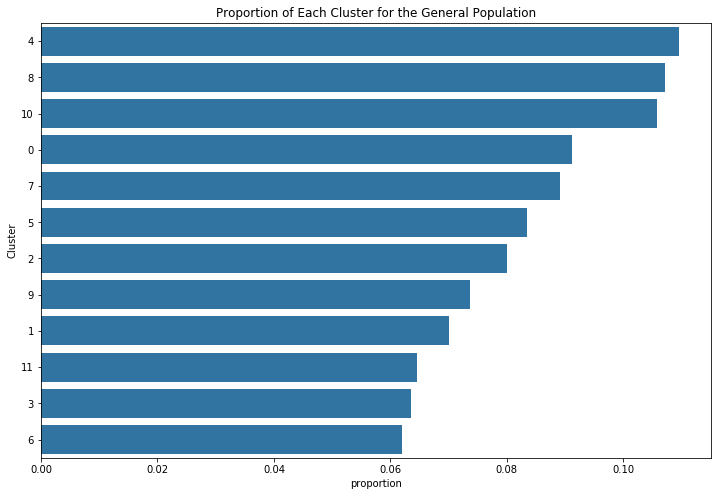

In [101]:
fig, ax = plt.subplots(figsize=(12,8))
show_proportion(azdias_clustered, title='Proportion of Each Cluster for the General Population')

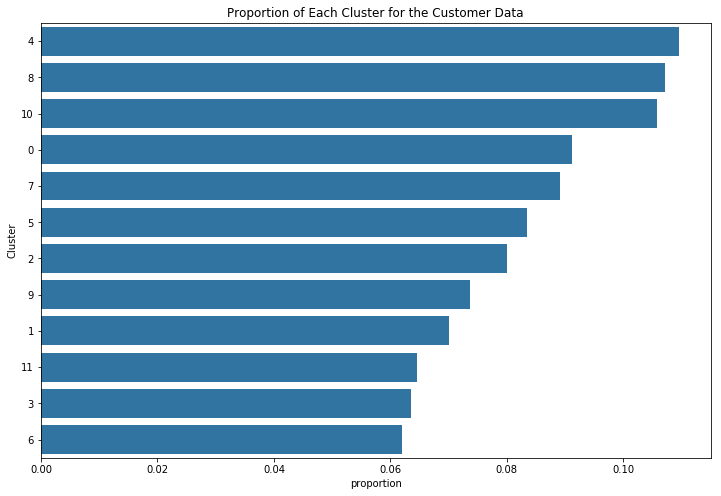

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
show_proportion(azdias_clustered, title='Proportion of Each Cluster for the Customer Data')

##### Analysis of data in clusters and also comparison between clusters of general population and customer data


In [105]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [106]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

,cluster,population,customer,difference
0,0,37883,NaN,NaN
1,1,29125,NaN,NaN
2,2,33243,1101.0,-6.905293
3,3,26364,308.0,-6.039624
4,4,45486,NaN,NaN
5,5,34694,5752.0,-2.619397
6,6,25778,48822.0,42.450572
7,7,37021,NaN,NaN
8,8,44496,NaN,NaN
9,9,30596,44147.0,36.631628


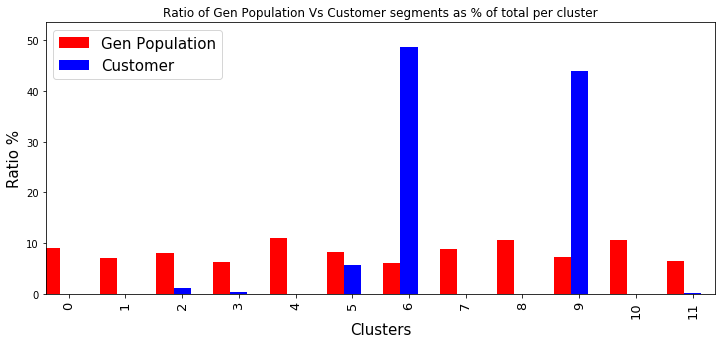

In [112]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='red',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='blue',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [113]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [114]:
# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(5,5)

Principal Component:  5


Highest Positive weights:
KBA13_KW_0_60          0.227
KBA13_KMH_180          0.187
KBA13_CCM_0_1400       0.184
OST_WEST_KZ_W          0.170
KBA13_SEG_MINIWAGEN    0.156
Name: 4, dtype: float64


Negative weights:
KBA13_KMH_210            -0.210
KBA13_CCM_1401_2500      -0.172
OST_WEST_KZ_O            -0.170
KBA13_CCM_2000           -0.131
KBA13_SEG_MITTELKLASSE   -0.121
Name: 4, dtype: float64


In [115]:
# Show lowest positive and negative weights for 10 cluster (under representation of Customer)
pca_weights(10,5)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.282
KBA05_KRSOBER    0.213
KBA05_CCM3       0.193
KBA05_HERST1     0.181
KBA05_KW2        0.167
Name: 9, dtype: float64


Negative weights:
KBA05_CCM1        -0.245
KBA05_MODTEMP     -0.219
KBA05_HERST3      -0.150
OST_WEST_KZ_W     -0.139
KBA05_HERSTTEMP   -0.137
Name: 9, dtype: float64


# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [182]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [117]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [118]:
# Total number of records
n_records = mailout_train.shape[0]

# Number of records where the individual became a customer
n_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
n_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
customer_perc = (n_customer / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals who became customers: {}".format(n_customer))
print("Individuals who did not become customers: {}".format(n_not_customer))
print("Percentage of individuals who became customers: {}%".format(customer_perc))

Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430
Percentage of individuals who became customers: 1.2383036171500394%


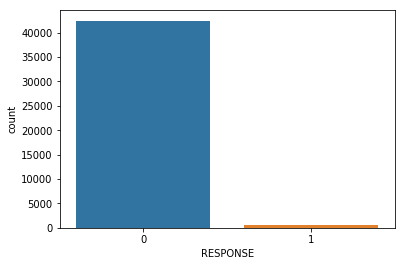

In [119]:
sns.countplot("RESPONSE",data=mailout_train)

#### Out of all the 42,962 individuals in the mailout campaign, only 1.24% of the individuals became customers. The dataset is highly imbalanced because of the disproportionate amount of customers and non-customers.

In [183]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

### Preparing the Data
Before the imbalanced dataset can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, the features are similar to the general population dataset and the customers dataset.

In [163]:
def data_preproces(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

In [184]:
# preprocess data
df_mailout_train  = data_preprocess_2(X, False)

shape after corr (42962, 253)
shape after one-hot (42962, 300)
shape after impute (42962, 300)
shape after scaling (42962, 300)


In [186]:
# Split the dataset into Train/Validation/Test

X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [187]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

[05:24:43] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
       scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [188]:
preds = xg_reg.predict(X_val)

#### Model Evaluation and Validation
In terms of evaluation metric to use, I have tried accuracy, precision, recall and fscore but due to very high imbalance (i.e. In MAILOUT_TRAIN dataset, we can find among 43000 individuals, only 532 people response to the mail-out campaign which means the training data is highly imbalanced.), none of these were a good way to measure and then finalised on AUC and ROC as the evaluation metric to proceed

In [196]:
from time import time 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [197]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

5

In [198]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)

result_list = []
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

print('result_list: ', result_list)

{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'roc': 0.7520605681485284}
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'roc': 0.76112332351690848}
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'roc': 0.78820888122056743}
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'roc': 0.72870910578577819}
{'alg_name': 'AdaBoostRegressor', 'fold': 5, 'roc': 0.73072796926347061}
{'alg_name': 'GradientBoostingRegressor', 'fold': 1, 'roc': 0.73311512529708089}
{'alg_name': 'GradientBoostingRegressor', 'fold': 2, 'roc': 0.75193446710469802}
{'alg_name': 'GradientBoostingRegressor', 'fold': 3, 'roc': 0.80506516837943964}
{'alg_name': 'GradientBoostingRegressor', 'fold': 4, 'roc': 0.73210648837819448}
{'alg_name': 'GradientBoostingRegressor', 'fold': 5, 'roc': 0.75577588391979689}
{'alg_name': 'XGBRegressor', 'fold': 1, 'roc': 0.5558291721824401}
{'alg_name': 'XGBRegressor', 'fold': 2, 'roc': 0.60636375250274777}
{'alg_name': 'XGBRegressor', 'fold': 3, 'roc': 0.65723789237767871}
{'alg_name': 'XGBRegressor',

In [199]:
df_scores = pd.DataFrame(result_list)
df_scores

,alg_name,fold,roc
0,AdaBoostRegressor,1,0.752061
1,AdaBoostRegressor,2,0.761123
2,AdaBoostRegressor,3,0.788209
3,AdaBoostRegressor,4,0.728709
4,AdaBoostRegressor,5,0.730728
5,GradientBoostingRegressor,1,0.733115
6,GradientBoostingRegressor,2,0.751934
7,GradientBoostingRegressor,3,0.805065
8,GradientBoostingRegressor,4,0.732106
9,GradientBoostingRegressor,5,0.755776


In [200]:
df_scores.groupby('alg_name')['roc'].mean()

alg_name
AdaBoostRegressor            0.752166
GradientBoostingRegressor    0.755599
XGBRegressor                 0.605846
Name: roc, dtype: float64

With XGBRegressor now finalised, now we need to test and finalise the hyperparameters best suited for our project. Using GridSearchCV to finalise on hyper parameters to use.

In [205]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'reg_alpha' : [0.05],
                'subsample' : [0.6],
                'colsample_bytree' : [0.7],
                'gamma' : [0.2],
                'max_depth' : [3],
                'min_child_weight' : [2],
                'objective' : ['binary:logistic'],
                'scale_pos_weight' : [1],
                'random_state' : [42],
                'scoring' : ['roc_auc']
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_xgb, parameters, scoring = 'roc_auc', n_jobs= -1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [206]:
roc_auc_score(y_val, best_predictions)

0.72427283116698316

### Final model for scoring

In [213]:
clf_final = xgb.XGBRegressor(
    objective = 'binary:logistic',
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.01,    
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,    
    scale_pos_weight = 1,
    random_state = 42,
    n_estimators = 500,
    scoring = 'roc_auc')

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

0.775990643857


In [214]:
feat_importance = clf_final.feature_importances_
feat_importance

array([ 0.00341953,  0.00324988,  0.00323133,  0.00377345,  0.00392225,
        0.00304779,  0.00158646,  0.00416888,  0.00240903,  0.00269469,
        0.00654597,  0.00326623,  0.00281847,  0.00285094,  0.00263035,
        0.00199622,  0.00212646,  0.00206379,  0.0019592 ,  0.00375027,
        0.00461571,  0.        ,  0.00482907,  0.00309237,  0.0017093 ,
        0.00265192,  0.00520303,  0.00135119,  0.00440843,  0.00102132,
        0.00657626,  0.00163337,  0.00309451,  0.00012241,  0.0047506 ,
        0.00450654,  0.00204041,  0.00295128,  0.00405032,  0.00377026,
        0.00412515,  0.00865746,  0.00508435,  0.00182782,  0.00408437,
        0.00490427,  0.00457868,  0.00409925,  0.00423773,  0.01315489,
        0.00447   ,  0.00166009,  0.00391318,  0.00410942,  0.00065127,
        0.        ,  0.00485176,  0.        ,  0.00266712,  0.00607258,
        0.        ,  0.00144846,  0.00274731,  0.00383783,  0.00251395,
        0.        ,  0.00400201,  0.00565246,  0.0043189 ,  0.00

['D19_SOZIALES' 'D19_LEBENSMITTEL' 'OST_WEST_KZ_W' 'KBA05_SEG8'
 'D19_DROGERIEARTIKEL']
[ 0.01315489  0.00865746  0.00738583  0.00720228  0.00657626]


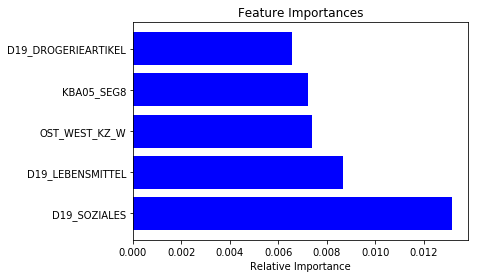

In [215]:
num_feat = 5
indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")

plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

From quick comparison of above charts, we can see drastic difference in the distribution of the most important feature "D19_SOZIALES". In Cluster 5 the over represented cluster of customer, there is a single bar and in Cluster 10 under represented cluster of customer there is a distribution and not a consolidation in 1 particular value

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [222]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [223]:
# as we want to make prediction using model trained with mailout_train, check/make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [224]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = data_preprocess_2(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

before preprocessing mailout_test.shape:  (42833, 366)
shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)
after preprocessing mailout_test_clean.shape:  (42833, 299)


In [228]:
# Cheking number of registers with missing value
mailout_test_clean.isnull().sum().sum()

0

In [227]:
prediction_for_kaggle = clf_final.predict(mailout_test_clean)

In [229]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)
df_kaggle.head(10)

,RESPONSE
LNR,
1754,0.034785
1770,0.030579
1465,0.008365
1470,0.009189
1478,0.012278
1782,0.007335
1485,0.007656
1519,0.025252
1835,0.026117


In [230]:
df_kaggle.to_csv('submission.csv')